## Solving SAT-NAE using (3,1)-QRAC

Suppose we take an easy CNF $(x_1 \lor x_2 \lor \neg x_3) \land (x_1 \lor \neg x_2 \lor x_3)$ (we know it has a solution $[1, 0, 0]$), we can transform this into a graph $G = (V,E)$ with 6 nodes (3 for the variables $x_1$ to $x_3$ and 3 for the variables $\neg x_1$ to $\neg x_3$). Previously, we have shown that it is possible to solve 3SAT-NAE on QAOA, but we will attempt to create a Hamiltonian to solve using QRAO for an arbitrary CNF

### Reading and transforming a CNF into a graph
First we will write a very simple parser for an input CNF formula, and then we will create a graph from that CNF. To make things not complicated, we will consider number variables $0$, $1$, ... so that we don't have too much trouble translating the input into a graph. Since we are treating the 3SAT-NAE case, we will treat this example expression: $\begin{equation}\texttt{0 1 2,0 n1 2}\end{equation}$ as $\begin{equation}(x_1 \lor x_2 \lor x_3) \land (x_1 \lor \neg x_2 \lor x_3)\end{equation}$
For creating the graph, we will use the convention that $\neg x_i$ will be node $x_{i+n}$ in the graph.

In [4]:
import networkx as nx

def parse_cnf_formula():
    # 1) Used inputs
    num_variables = int(input("Enter the number of variables: "))
    cnf = input("Enter the CNF of the form above (ex: 0 1 2,0 n1 2): ")
    # 2) Separating the CNF into clauses
    clauses = cnf.replace(",", " ")
    individual_variables = clauses.split(" ")
    for i in range(len(individual_variables)):
        if individual_variables[i].startswith("n"):
            individual_variables[i] = str(int(individual_variables[i][1:])+num_variables)

    print(individual_variables)
    
    G = nx.Graph()
    return G
obtained_graph = parse_cnf_formula()

['0', '1', '2', '0', '4', '2']


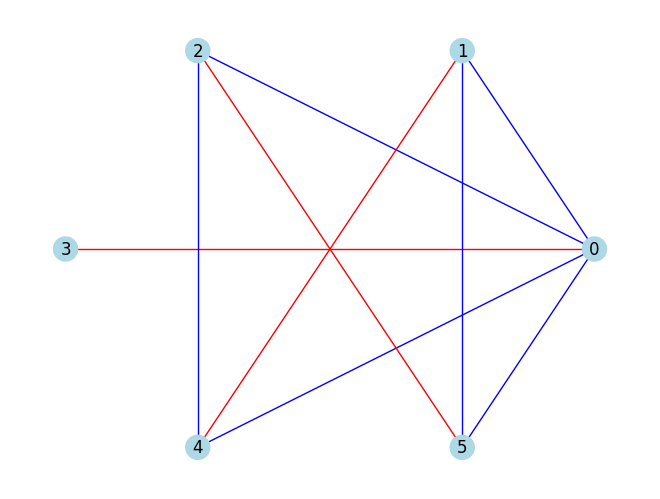

In [46]:
G = nx.Graph()

labels = [0, 1, 2, 3, 4, 5]
node_color_map = ["lightblue"]*len(labels)
G.add_nodes_from(labels)

# clause 1
G.add_edge(0, 1, color="b")
G.add_edge(0, 5, color="b")
G.add_edge(1, 5, color="b")

# clause 2
G.add_edge(0, 4, color="b")
G.add_edge(0, 2, color="b")
G.add_edge(4, 2, color="b")

G.add_edge(0, 3, color="r")
G.add_edge(1, 4, color="r")
G.add_edge(2, 5, color="r")

edge_colors = [G[u][v]['color'] for u,v in G.edges()]

nx.draw_circular(G, with_labels=True, node_color=node_color_map, edge_color=edge_colors)

### Graph coloring
Now we color this graph to assign neighboring nodes a different color

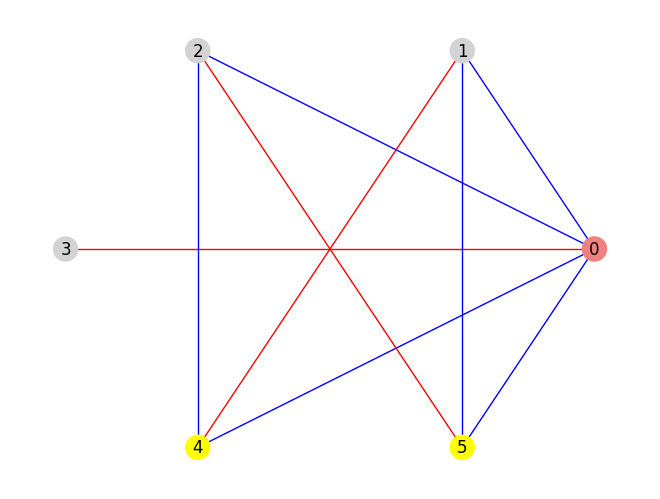

In [47]:
# first set up the colors (we only need 6 in our case)
colors_list = ["lightcoral", "lightgray", "yellow", "lime", "lightblue", "green"]
colors = nx.greedy_color(G)
new_node_colors = list(map(lambda elem: colors_list[colors[elem]], labels.copy()))
nx.draw_circular(G, with_labels=True, node_color=new_node_colors, edge_color=edge_colors)

In [60]:
# Display the colorings
print(colors)
num_colors = len(set(colors.values()))
print(list(colors.keys()))

{0: 0, 1: 1, 2: 1, 4: 2, 5: 2, 3: 1}
[0, 1, 2, 4, 5, 3]


Now that we got our colored graph, we can transform the colors list into a set of list of vertices $V_{c_i}$ where each set contains vertices of the same color $c_i$. We can do this based off the `colors` variable obtained through greedy graph coloring.

In [95]:
nodes_grouped_by_color = []
for i in range(num_colors):
    nodes_grouped_by_color.append([])
for vertex in G.nodes():
    nodes_grouped_by_color[colors[vertex]].append(vertex)
print(nodes_grouped_by_color)

[[0], [1, 2, 3], [4, 5]]


We need $\lceil\frac{|V_c|}{3}\rceil$ qubits for color $c$. So the total number of qubits needed is going to be $\sum\limits_{c \in C}\lceil\frac{|V_c|}{3}\rceil$. In this next cell, we create the qubit mappings, i.e. which qubit corresponds to which Vertex. The way we proceed is greedily assigning qubits to vertices. (https://arxiv.org/pdf/2302.00429.pdf [paper by Kosei Teramoto])

In [118]:
import math

def create_qubit_to_vertices_mapping(nodes_grouped_by_color, bits_per_qubit=3):
    num_qubits_needed = 0
    for i in range(len(nodes_grouped_by_color)):
        num_qubits_needed += math.ceil(len(nodes_grouped_by_color[i])/bits_per_qubit)

    ## qubit q_i maps to a list of vertices associated with qubit q_i (max 3 vertices per qubit)
    qubit_mappings = []

    for elem in nodes_grouped_by_color:
        # this case covers when we need one qubit for a color
        if len(elem) <= bits_per_qubit:
            qubit_mappings.append(elem)
        # this case covers when we need more than one qubit for a color (split the list and assign more than one qubits)
        else:
            first_index = 0
            second_index = bits_per_qubit # slicing the list (i.e. second index will be exluded from the slice)
            while first_index < len(elem):
                # make sure not to go too far in the slice in case the length is not a multiple of 3
                if second_index > len(elem):
                    second_index = len(elem)
                    # append sliced list (max size = bits_per_qubit), i.e. if bpq=3 then for [1,2,3,4,5], we append [1,2,3] and [4,5]
                qubit_mappings.append(elem[first_index:second_index])
                # increase the indices for appending the next element
                first_index += bits_per_qubit
                second_index += bits_per_qubit
    return qubit_mappings

### Print the mappings obtained

In [119]:
qubit_mappings = create_qubit_to_vertices_mapping(nodes_grouped_by_color)    
# Print the qubit -> vertices mappings
for i in range(len(qubit_mappings)):
    print(f"Qubit {i} -> vertices {qubit_mappings[i]}")

Qubit 0 -> vertices [0]
Qubit 1 -> vertices [1, 2, 3]
Qubit 2 -> vertices [4, 5]


### Assign X, Y and Z Pauli operators respectively to each vertex per qubit
We will have a "vertex (index) -> Pauli Operator" mapping, to later construct the Hamiltonian based on this mapping

In [120]:
from qiskit.opflow import X, Y, Z, I

def create_vertex_to_operator_mapping(qubit_mappings, G):
    mappings = [I]*G.number_of_nodes()

    qrac_3_operators = [X, Y, Z] # Not easy to generalize but we use for (3,1)-QRAC here

    for vertex_groups in qubit_mappings:
        for i in range(len(vertex_groups)):
            mappings[vertex_groups[i]] = qrac_3_operators[i] # assign a different operator per vertex in the same group

    return mappings

vertex_to_operator_mappings = create_vertex_to_operator_mapping(qubit_mappings, G)

### Display the operator assignments for each vertex

In [122]:
for i in range(len(vertex_to_operator_mappings)):
    print(f"Vertex {i} -> {vertex_to_operator_mappings[i]}")

Vertex 0 -> X
Vertex 1 -> X
Vertex 2 -> Y
Vertex 3 -> Z
Vertex 4 -> X
Vertex 5 -> Y


### Create the Hamiltonian based on the operator assignment for each qubit
We know from Teramoto-san's paper (see above), that the max-cut Hamiltonian formulation in this case (for a triangle graph) is the following:
$\begin{equation}
\frac{1}{2}\sum\limits_{(v_i,v_j)\in E(G)}(I - 3P_iP_j)\end{equation}$, where $P_k$ corresponds to the pauli operator assigned to vertex $k$.
Actually this is similar to finding the ground state of $\begin{equation}\sum\limits_{c\in C}(P_iP_j + P_iP_k + P_jP_k) + H_{pen}\end{equation}$.
where $C$ corresponds to the set of clauses of the CNF, $H_{pen}$ is the penalty Hamiltonian of the 3SAT-NAE problem, and $P_l$ is the Pauli operator of vertex $l$ applied on the qubit corresponding to vertex $l$.

To get $H_{pen}$, we can simply replace $Z_iZ_j$ from the original (non-QRAC) Hamiltonian form with $P_iP_j$. Thus our final Hamiltonian for will be given by:
$\begin{equation}\sum\limits_{c\in C}(P_iP_j + P_iP_k + P_jP_k) + M\sum\limits_{v_i \in V(G)} P_{v_i}P_{\neg v_i})\end{equation}$

We will now design this Hamiltonian given an input CNF.

In [15]:
from qiskit.opflow import X, Y, Z, I

M_FACTOR = 10

# Create the Problem Hamiltonian

H = (X ^ X ^ I ^ I) + (X ^ I ^ I ^ X) + (I ^ X ^ I ^ X) + (Y ^ I ^ Z ^ I)
H += (Y ^ I ^ I ^ Z) + (I ^ I ^ Z ^ Z) + (Z ^ Y ^ I ^ I) + (Z ^ I ^ X ^ I)
H += (I ^ Y ^ X ^ I) + (I ^ I ^ Y ^ Y) + (I ^ Z ^ Y ^ I) + (I ^ Z ^ I ^ Y)
H += M_FACTOR * ((X ^ I ^ Z ^ I) + (Z ^ X ^ I ^ I) + (Y ^ I ^ I ^ X) + (I ^ Y ^ I ^ Y) + (I ^ Z ^ X ^ I) + (I ^ I ^ Y ^ Z))

In [19]:
# Cell copied from https://qiskit.org/documentation/tutorials/algorithms/05_qaoa.html
from collections import OrderedDict
from qiskit.opflow import StateFn
import numpy as np


def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector (numpy.ndarray or dict): state vector or counts.
    Returns:
        numpy.ndarray: binary string as numpy.ndarray of ints.
    """
    if isinstance(state_vector, (OrderedDict, dict)):
        # get the binary string with the largest count
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    elif isinstance(state_vector, StateFn):
        binary_string = list(state_vector.sample().keys())[0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x

In [16]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-utokyo", group="internal", project="hirashi-jst")
backend = provider.get_backend("ibmq_qasm_simulator")

ibmqfactory.load_account:WARNING:2023-04-24 17:23:44,526: Credentials are already in use. The existing account in the session will be replaced.


In [17]:
from qiskit_optimization.runtime import QAOAClient
from qiskit.algorithms.optimizers import COBYLA

# Running using Qiskit Runtime
qaoa = QAOAClient(optimizer=COBYLA(), provider=provider, backend=backend)

In [18]:
result = qaoa.compute_minimum_eigenvalue(H)

In [20]:
output = list(sample_most_likely(result.eigenstate))[::-1]
print(f"full output: {output}")

full output: [1, 1, 1, 0]
